# Pre-processing & Training Data Development

## 1. Imports packages

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.dummy import DummyRegressor
import datetime
import scipy.stats as stats
from scipy.stats import uniform, randint, skew, f_oneway
# from scipy.stats import skew, f_oneway

# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
#njobs = 4

from library.sb_utils import save_file
print("Loaded Libraries")

Loaded Libraries


In [2]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, Ridge
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, scale, StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer
from sklearn.feature_selection import SelectKBest, f_regression
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor

In [3]:
sns.set()

## 2. Load Data

We will use the cleaned data in EDA step

In [4]:
df_cleaned = pd.read_csv('../data/house_price_preprocessing_data.csv')
df_cleaned.shape

print('The data have ', df_cleaned.shape[0], ' rows and ', df_cleaned.shape[1], ' columns\n')
print('column names: \n')
print('\n'.join(list(df_cleaned.columns)))

The data have  1456  rows and  79  columns

column names: 

MSSubClass
MSZoning
LotFrontage
LotArea
Street
Alley
LotShape
LandContour
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
OverallQual
OverallCond
YearBuilt
YearRemodAdd
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
MasVnrArea
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinSF1
BsmtFinType2
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
Heating
HeatingQC
CentralAir
Electrical
1stFlrSF
2ndFlrSF
LowQualFinSF
GrLivArea
BsmtFullBath
BsmtHalfBath
FullBath
HalfBath
BedroomAbvGr
KitchenAbvGr
KitchenQual
TotRmsAbvGrd
Functional
Fireplaces
FireplaceQu
GarageType
GarageYrBlt
GarageFinish
GarageCars
GarageArea
GarageQual
GarageCond
PavedDrive
WoodDeckSF
OpenPorchSF
EnclosedPorch
3SsnPorch
ScreenPorch
PoolArea
PoolQC
Fence
MiscFeature
MiscVal
MoSold
YrSold
SaleType
SaleCondition
SalePrice


In [5]:
df_cleaned.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.000,8450,2,No,4,Lvl,Inside,3,...,0,No,No,No,0,2,2008,WD,Normal,12.248
1,20,RL,80.000,9600,2,No,4,Lvl,FR2,3,...,0,No,No,No,0,5,2007,WD,Normal,12.109
2,60,RL,68.000,11250,2,No,3,Lvl,Inside,3,...,0,No,No,No,0,9,2008,WD,Normal,12.317
3,70,RL,60.000,9550,2,No,3,Lvl,Corner,3,...,0,No,No,No,0,2,2006,WD,Abnorml,11.849
4,60,RL,84.000,14260,2,No,3,Lvl,FR2,3,...,0,No,No,No,0,12,2008,WD,Normal,12.429


## 3. Determine the importance of categorical/numeric features vs target variable

#### 3.1 Use Anova to rank the categorical features vs our target variable SalePrice

In [6]:
# Separate the feature and target variable
target = df_cleaned['SalePrice']

anova_results = {}

for feature in df_cleaned.select_dtypes(include=['object']):
    # Perform ANOVA test for the current feature
    f_statistic, p_value = f_oneway(*(target[df_cleaned[feature] == category] for category in df_cleaned[feature].unique()))
    # Store the ANOVA results for the current feature in the dictionary
    anova_results[feature] = {'f_statistic': f_statistic, 'p_value': p_value}

# Sort the ANOVA results by the F-statistic in descending order
sorted_results = sorted(anova_results.items(), key=lambda x: x[1]['f_statistic'], reverse=True)

# Print the sorted ANOVA results
for feature, results in sorted_results:
    print('{}: F-statistic: {:.2f}, p-value: {:.2f}'.format(feature, results['f_statistic'], results['p_value']))

GarageFinish: F-statistic: 299.42, p-value: 0.00
CentralAir: F-statistic: 207.92, p-value: 0.00
FireplaceQu: F-statistic: 129.58, p-value: 0.00
Foundation: F-statistic: 126.84, p-value: 0.00
GarageType: F-statistic: 123.43, p-value: 0.00
MasVnrType: F-statistic: 90.47, p-value: 0.00
Neighborhood: F-statistic: 79.05, p-value: 0.00
MSZoning: F-statistic: 78.41, p-value: 0.00
BsmtFinType1: F-statistic: 70.55, p-value: 0.00
BsmtExposure: F-statistic: 62.15, p-value: 0.00
GarageCond: F-statistic: 49.91, p-value: 0.00
GarageQual: F-statistic: 48.39, p-value: 0.00
SaleCondition: F-statistic: 45.90, p-value: 0.00
Electrical: F-statistic: 39.17, p-value: 0.00
BsmtCond: F-statistic: 34.95, p-value: 0.00
SaleType: F-statistic: 25.80, p-value: 0.00
Exterior1st: F-statistic: 23.96, p-value: 0.00
HouseStyle: F-statistic: 23.07, p-value: 0.00
Alley: F-statistic: 20.79, p-value: 0.00
Exterior2nd: F-statistic: 20.19, p-value: 0.00
Fence: F-statistic: 17.19, p-value: 0.00
BldgType: F-statistic: 15.24, p

#### 3.2 Use Pearson correlation coefficient to measure the linear association between numeric features and  target variable 

In [7]:
# Select the numeric features and the target variable
num_features = df_cleaned.select_dtypes(exclude=['object']).columns
target_var = 'SalePrice'

# Calculate the Pearson correlation coefficient between each numeric feature and the target variable
corr_results = {}
for feature in num_features:
    corr_coef = df_cleaned[feature].corr(df_cleaned[target_var])
    corr_results[feature] = corr_coef

# Create a DataFrame to store the results
result_df = pd.DataFrame.from_dict(corr_results, orient='index', columns=['Correlation Coefficient'])

# Sort the DataFrame by correlation coefficient in descending order
result_df = result_df.sort_values(by='Correlation Coefficient', ascending=False)

# Print the resulting DataFrame
print(result_df)

               Correlation Coefficient
SalePrice                        1.000
OverallQual                      0.819
GrLivArea                        0.719
ExterQual                        0.681
GarageCars                       0.680
KitchenQual                      0.667
GarageArea                       0.655
TotalBsmtSF                      0.642
BsmtQual                         0.615
1stFlrSF                         0.614
FullBath                         0.591
YearBuilt                        0.589
YearRemodAdd                     0.569
TotRmsAbvGrd                     0.533
Fireplaces                       0.487
HeatingQC                        0.474
MasVnrArea                       0.426
BsmtFinSF1                       0.383
LotFrontage                      0.361
GarageYrBlt                      0.351
WoodDeckSF                       0.331
OpenPorchSF                      0.327
HalfBath                         0.311
2ndFlrSF                         0.307
PavedDrive               

## 4. Encode some categorical features as ordered numbers when there is information in the order

In [8]:
train = df_cleaned

# Encode some categorical features as ordered numbers when there is information in the order
train = train.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )

## 5. Create new features

Simplifications of existing features

In [9]:
# Create new features
# 1* Simplifications of existing features
train["SimplOverallQual"] = train.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
train["SimplOverallCond"] = train.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
train["SimplPoolQC"] = train.PoolQC.replace({1 : 1, 2 : 1, # average
                                             3 : 2, 4 : 2 # good
                                            })
train["SimplGarageCond"] = train.GarageCond.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
train["SimplGarageQual"] = train.GarageQual.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
train["SimplFireplaceQu"] = train.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
train["SimplFireplaceQu"] = train.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
train["SimplFunctional"] = train.Functional.replace({1 : 1, 2 : 1, # bad
                                                     3 : 2, 4 : 2, # major
                                                     5 : 3, 6 : 3, 7 : 3, # minor
                                                     8 : 4 # typical
                                                    })
train["SimplKitchenQual"] = train.KitchenQual.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
train["SimplHeatingQC"] = train.HeatingQC.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
train["SimplBsmtFinType1"] = train.BsmtFinType1.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
train["SimplBsmtFinType2"] = train.BsmtFinType2.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
train["SimplBsmtCond"] = train.BsmtCond.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
train["SimplBsmtQual"] = train.BsmtQual.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
train["SimplExterCond"] = train.ExterCond.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
train["SimplExterQual"] = train.ExterQual.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })

In [10]:
# Find most important features relative to target
print("Find most important features relative to target")
corr = train.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

Find most important features relative to target
SalePrice           1.000
OverallQual         0.819
GrLivArea           0.719
SimplOverallQual    0.708
ExterQual           0.681
GarageCars          0.680
KitchenQual         0.667
GarageArea          0.655
TotalBsmtSF         0.642
SimplExterQual      0.636
BsmtQual            0.615
1stFlrSF            0.614
SimplKitchenQual    0.610
SimplBsmtQual       0.594
FullBath            0.591
YearBuilt           0.589
YearRemodAdd        0.569
TotRmsAbvGrd        0.533
Fireplaces          0.487
HeatingQC           0.474
MasVnrArea          0.426
SimplHeatingQC      0.398
BsmtFinSF1          0.383
LotFrontage         0.361
GarageYrBlt         0.351
WoodDeckSF          0.331
OpenPorchSF         0.327
HalfBath            0.311
2ndFlrSF            0.307
PavedDrive          0.306
LotArea             0.259
BsmtFullBath        0.239
BsmtUnfSF           0.223
BedroomAbvGr        0.204
SimplFunctional     0.137
Functional          0.136
ScreenPorch     

## 6. Differentiate numerical features (minus the target) and categorical features


In [11]:
categorical_features = train.select_dtypes(include = ["object"]).columns
numerical_features = train.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop("SalePrice")
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
train_num = train[numerical_features]
train_cat = train[categorical_features]

Numerical features : 54
Categorical features : 39


## 7. Log transform of the skewed numerical features to lessen impact of outliers

In [12]:
# As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed
skewness = train_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
train_num[skewed_features] = np.log1p(train_num[skewed_features])

41 skewed numerical features to log transform


/var/folders/3t/zg2pg4h96j33j992z6f26cgh0000gn/T/ipykernel_16255/3352021519.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_num[skewed_features] = np.log1p(train_num[skewed_features])


## 8.Transformation of categorical features

In [13]:
# Create dummy features for categorical values via one-hot encoding
train_cat = pd.get_dummies(train_cat)

train_cat.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_1,Alley_2,Alley_No,LandContour_Bnk,LandContour_HLS,...,SimplBsmtFinType2_2,SimplBsmtFinType2_3,SimplBsmtFinType2_4,SimplBsmtFinType2_5,SimplBsmtFinType2_6,SimplBsmtCond_0,SimplBsmtCond_1,SimplBsmtCond_2,SimplBsmtCond_3,SimplBsmtCond_4
0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


## 9. Split into testing and training datasets 

In [14]:
from sklearn.model_selection import train_test_split

# Join categorical and numerical features
X = pd.concat([train_num, train_cat], axis = 1)
y = train.SalePrice
print("New number of features : " + str(X.shape[1]))

# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

New number of features : 316
X_train : (1164, 316)
X_test : (292, 316)
y_train : (1164,)
y_test : (292,)


## 10.Standardize the magnitude of numeric features using a scaler 

Standardization cannot be done before train & test split, as we don't want to fit the StandardScaler on some observations that will later be used in the test set.

In [15]:
# Standardize numerical features
stdSc = StandardScaler()
X_train.loc[:, numerical_features] = stdSc.fit_transform(X_train.loc[:, numerical_features])
X_test.loc[:, numerical_features] = stdSc.transform(X_test.loc[:, numerical_features])

# Modeling

In [16]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, Ridge
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, scale, StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer
from sklearn.feature_selection import SelectKBest, f_regression
import xgboost as xgb
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import randint as sp_randint

#### Simple Linear Regression

In [17]:
# Create a Linear Regression object
lr_model = LinearRegression()

# Fit the model to the training data
lr_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = lr_model.predict(X_test)

# Calculate R2 and RMSE scores on the testing data
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("R2 score on the testing data: ", r2)
print("RMSE score on the testing data: ", rmse)

R2 score on the testing data:  -6482216111064935.0
RMSE score on the testing data:  31996739.15555886


Simple linear regression model perform poorly which is expected since we have too many features for a simple linear regression to  handle. 

In [18]:
# Create a KFold object
kf = KFold(n_splits=10, shuffle=True, random_state=42)

In [19]:
# Create a dataframe to store the results for each model
results_df = pd.DataFrame(columns=['Model', 'R2', 'RMSE'])

#### Ridge w/ hyperparameter tuning - RandomizedSearchCV

In [20]:
# Create the parameter space
ridge_param_grid = {"alpha": np.arange(0.0001, 1.0, 10),
              "solver": ["sag","lsqr"]}

# Create a Ridge Regressor object
ridge_model = Ridge()

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=ridge_model, param_distributions=ridge_param_grid, n_iter=100, cv=kf)

# Fit the model to the training data
random_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters: ", random_search.best_params_)

# Train the Ridge Regressor with the best hyperparameters on the entire training set
ridge_model = Ridge(**random_search.best_params_)
ridge_model.fit(X_train, y_train)

# Make predictions on the testing data
ridge_y_pred = ridge_model.predict(X_test)

# Calculate R2 and RMSE scores on the testing data
Ridge_r2 = r2_score(y_test, ridge_y_pred)
Ridge_rmse = mean_squared_error(y_test, ridge_y_pred, squared=False)
print("R2 score on the testing data: ", Ridge_r2)
print("RMSE score on the testing data: ", Ridge_rmse)

# Append the results to the dataframe
results_df = results_df.append({'Model': 'Ridge', 'R2': Ridge_r2, 'RMSE': Ridge_rmse}, ignore_index=True)

/Users/tsaijungwang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 2 is smaller than n_iter=100. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best hyperparameters:  {'solver': 'sag', 'alpha': 0.0001}
R2 score on the testing data:  0.9031133578552614
RMSE score on the testing data:  0.12370177181261766


/var/folders/3t/zg2pg4h96j33j992z6f26cgh0000gn/T/ipykernel_16255/2422467705.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': 'Ridge', 'R2': Ridge_r2, 'RMSE': Ridge_rmse}, ignore_index=True)


#### Lasso w/ hyperparameter tuning - RandomizedSearchCV

In [21]:
# Set up the parameter grid
lasso_params = {"alpha": np.linspace(0.00001, 1, 20)}

# Create a Lasso Regressor object
lasso_model = Lasso()

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=lasso_model, param_distributions=lasso_params, n_iter=20, cv=kf)

# Fit the model to the training data
random_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters: ", random_search.best_params_)

# Train the Lasso Regressor with the best hyperparameters on the entire training set
lasso_model = Lasso(**random_search.best_params_)
lasso_model.fit(X_train, y_train)

# Make predictions on the testing data
lasso_y_pred = lasso_model.predict(X_test)

# Calculate R2 and RMSE scores on the testing data
lasso_r2 = r2_score(y_test, lasso_y_pred)
lasso_rmse = mean_squared_error(y_test, lasso_y_pred, squared=False)
print("R2 score on the testing data: ", lasso_r2)
print("RMSE score on the testing data: ", lasso_rmse)

# Append the results to the dataframe
results_df = results_df.append({'Model': 'Lasso', 'R2': lasso_r2, 'RMSE': lasso_rmse}, ignore_index=True)

/Users/tsaijungwang/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.372e-01, tolerance: 1.655e-02
  model = cd_fast.enet_coordinate_descent(
/Users/tsaijungwang/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.149e-01, tolerance: 1.677e-02
  model = cd_fast.enet_coordinate_descent(
/Users/tsaijungwang/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

Best hyperparameters:  {'alpha': 1e-05}
R2 score on the testing data:  0.898276897868292
RMSE score on the testing data:  0.12675169212441617


/Users/tsaijungwang/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.694e-01, tolerance: 1.819e-02
  model = cd_fast.enet_coordinate_descent(
/var/folders/3t/zg2pg4h96j33j992z6f26cgh0000gn/T/ipykernel_16255/4109161514.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': 'Lasso', 'R2': lasso_r2, 'RMSE': lasso_rmse}, ignore_index=True)


#### ElasticNet 

In [22]:
# Define the parameter grid
en_param_dist = {"alpha": uniform(0, 1),
              "l1_ratio": uniform(0, 1)}

# Create an ElasticNet model object
enet_model = ElasticNet()

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=enet_model, param_distributions=en_param_dist, n_iter=100, cv=5, random_state=42)

# Fit the model to the training data
random_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters: ", random_search.best_params_)
print("Best R2 score: ", random_search.best_score_)
# print("Best RMSE score: ", -random_search.cv_results_['mean_test_rmse_score'][random_search.best_index_])


# Train the ElasticNet model with the best hyperparameters on the entire training set
enet_model = ElasticNet(**random_search.best_params_)
enet_model.fit(X_train, y_train)

# Make predictions on the testing data
enet_y_pred = enet_model.predict(X_test)

# Calculate R2 and RMSE scores on the testing data
enet_r2 = r2_score(y_test, enet_y_pred)
enet_rmse = mean_squared_error(y_test, enet_y_pred, squared=False)
print("R2 score on the testing data: ", enet_r2)
print("RMSE score on the testing data: ", enet_rmse)

# Append the results to the dataframe
results_df = results_df.append({'Model': 'ElasticNet', 'R2': enet_r2, 'RMSE': enet_rmse}, ignore_index=True)


Best hyperparameters:  {'alpha': 0.02541912674409519, 'l1_ratio': 0.10789142699330445}
Best R2 score:  0.9087384467239378
R2 score on the testing data:  0.9039705214721778
RMSE score on the testing data:  0.12315335657830474


/var/folders/3t/zg2pg4h96j33j992z6f26cgh0000gn/T/ipykernel_16255/3034792444.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': 'ElasticNet', 'R2': enet_r2, 'RMSE': enet_rmse}, ignore_index=True)


#### XGBoost

In [23]:
# Define the parameter grid
xg_param_dist = {"learning_rate": uniform(0, 1),
              "max_depth": randint(1, 10),
              "min_child_weight": randint(1, 10),
              "subsample": uniform(0.5, 0.5), # can skip
              "colsample_bytree": uniform(0.5, 0.5),
              "gamma": uniform(0, 1)}

# Create an XGBoost model object
xgb_model = xgb.XGBRegressor()

# Create scorer objects for the R2 and RMSE scores
scorers = {'r2_score': make_scorer(r2_score),
           'rmse_score': make_scorer(mean_squared_error, squared=False)}

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=xgb_model, 
                                   param_distributions=xg_param_dist, 
                                   n_iter=100, cv=5, 
                                   scoring=scorers, 
                                   refit='r2_score', 
                                   random_state=42)

# Fit the model to the training data
random_search.fit(X_train, y_train)

# Print the best hyperparameters and the best scores
print("Best hyperparameters: ", random_search.best_params_)
# print("Best R2 score: ", random_search.best_score_)
# print("Best RMSE score: ", -random_search.cv_results_['mean_test_rmse_score'][random_search.best_index_])

# Train the XGBoost model with the best hyperparameters on the entire training set
xgb_model = xgb.XGBRegressor(**random_search.best_params_)
xgb_model.fit(X_train, y_train)

# Make predictions on the testing data
xgb_y_pred = xgb_model.predict(X_test)

# Calculate R2 and RMSE scores on the testing data
xgb_r2 = r2_score(y_test, xgb_y_pred)
xgb_rmse = mean_squared_error(y_test, xgb_y_pred, squared=False)
print("R2 score on the testing data: ", xgb_r2)
print("RMSE score on the testing data: ", xgb_rmse)

# Append the results to the dataframe
results_df = results_df.append({'Model': 'XGBoost', 'R2': xgb_r2, 'RMSE': xgb_rmse}, ignore_index=True)


Best hyperparameters:  {'colsample_bytree': 0.8531211135782482, 'gamma': 0.08134878064189976, 'learning_rate': 0.08483771408519192, 'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.6871353978780601}
R2 score on the testing data:  0.8984794608311326
RMSE score on the testing data:  0.12662542782273986


/var/folders/3t/zg2pg4h96j33j992z6f26cgh0000gn/T/ipykernel_16255/4011362211.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': 'XGBoost', 'R2': xgb_r2, 'RMSE': xgb_rmse}, ignore_index=True)


#### Gradient Boosting Regression

In [24]:
# Define the parameter grid
gb_param_dist = {"learning_rate": uniform(0, 1),
              "n_estimators": randint(50, 100),
              "max_depth": randint(1, 10),
              "min_samples_split": randint(2, 10),
              "min_samples_leaf": randint(1, 5)}

# Create a Gradient Boosting Regressor object
gbr_model = GradientBoostingRegressor()

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=gbr_model, param_distributions=gb_param_dist, n_iter=100, cv=5, random_state=42)

# Fit the model to the training data
random_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters: ", random_search.best_params_)

# Train the Gradient Boosting Regressor with the best hyperparameters on the entire training set
gbr_model = GradientBoostingRegressor(**random_search.best_params_)
gbr_model.fit(X_train, y_train)

# Make predictions on the testing data
gbr_y_pred = gbr_model.predict(X_test)

# Calculate R2 and RMSE scores on the testing data
gb_r2 = r2_score(y_test, gbr_y_pred)
gb_rmse = mean_squared_error(y_test, gbr_y_pred, squared=False)
print("R2 score on the testing data: ", r2)
print("RMSE score on the testing data: ", rmse)

# Append the results to the dataframe
results_df = results_df.append({'Model': 'Gradient Boosting', 'R2': gb_r2, 'RMSE': gb_rmse}, ignore_index=True)


Best hyperparameters:  {'learning_rate': 0.19438003399487302, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 9, 'n_estimators': 65}
R2 score on the testing data:  -6482216111064935.0
RMSE score on the testing data:  31996739.15555886


/var/folders/3t/zg2pg4h96j33j992z6f26cgh0000gn/T/ipykernel_16255/583161334.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': 'Gradient Boosting', 'R2': gb_r2, 'RMSE': gb_rmse}, ignore_index=True)


#### Light GBM

In [25]:
# Create a Light GBM Regressor object
lgb_model = lgb.LGBMRegressor()

# Define the parameter grid for the Light GBM Regressor
lgb_param_dist = {"num_leaves": sp_randint(6, 50),
              "max_depth": sp_randint(1, 20),
              "learning_rate": [0.01, 0.05, 0.1, 0.2],
              "n_estimators": sp_randint(50, 500),
              "min_child_samples": sp_randint(10, 50)}

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=lgb_model, param_distributions=lgb_param_dist, n_iter=100, cv=5, random_state=42)

# Fit the model to the training data
random_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters: ", random_search.best_params_)

# Train the Light GBM Regressor with the best hyperparameters on the entire training set
lgb_model = lgb.LGBMRegressor(**random_search.best_params_)
lgb_model.fit(X_train, y_train)

# Make predictions on the testing data
lgb_y_pred = lgb_model.predict(X_test)

# Calculate R2 and RMSE scores on the testing data
lgb_r2 = r2_score(y_test, lgb_y_pred)
lgb_rmse = mean_squared_error(y_test, lgb_y_pred, squared=False)
print("R2 score on the testing data: ", r2)
print("RMSE score on the testing data: ", rmse)

# Append the results to the dataframe
results_df = results_df.append({'Model': 'Light GBM', 'R2': lgb_r2, 'RMSE': lgb_rmse}, ignore_index=True)


Best hyperparameters:  {'learning_rate': 0.1, 'max_depth': 9, 'min_child_samples': 21, 'n_estimators': 178, 'num_leaves': 6}
R2 score on the testing data:  -6482216111064935.0
RMSE score on the testing data:  31996739.15555886


/var/folders/3t/zg2pg4h96j33j992z6f26cgh0000gn/T/ipykernel_16255/3807524513.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': 'Light GBM', 'R2': lgb_r2, 'RMSE': lgb_rmse}, ignore_index=True)


#### Comparing Model Result

In [26]:
results_df

# results_df.drop(index=results_df.index[-1], inplace=True)

,Model,R2,RMSE
0,Ridge,0.903,0.124
1,Lasso,0.898,0.127
2,ElasticNet,0.904,0.123
3,XGBoost,0.898,0.127
4,Gradient Boosting,0.890,0.132
5,Light GBM,0.891,0.131


#### Plotting feature importance for the best regression based model
Since ElasticNet provides the best score, will plot freature importantce and select top 20 features to see how the model performs

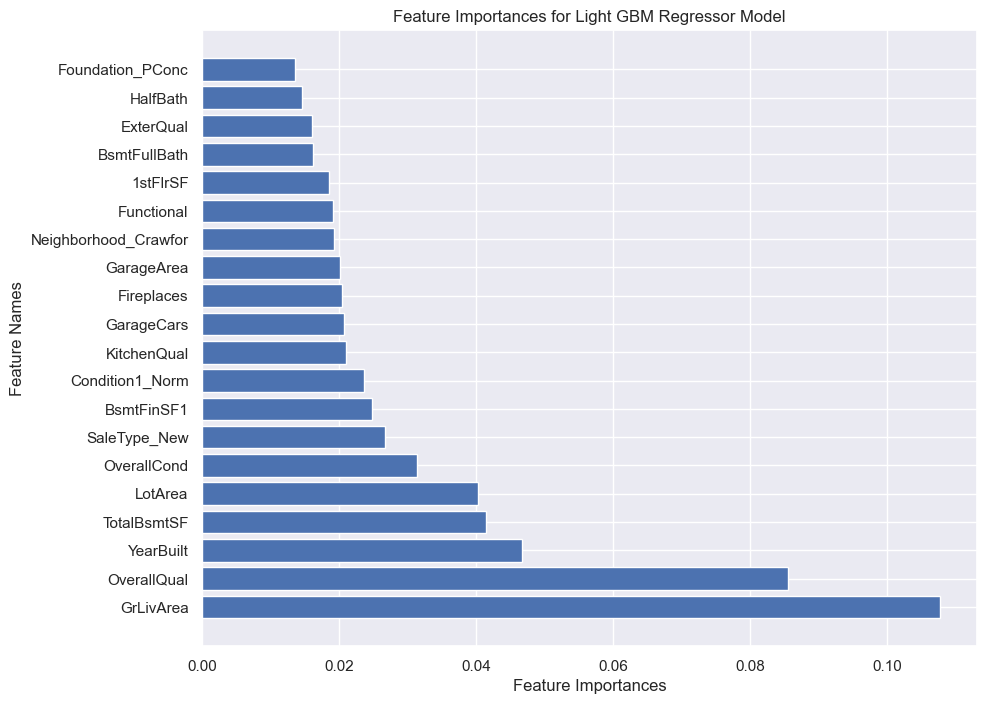

In [27]:
# Get the feature importances from the trained Light GBM Regressor model
feature_importances = enet_model.coef_

# Get the feature names from the column names of the training data
feature_names = list(X_train.columns)

# Get the non-zero feature importances and corresponding feature names
nonzero_features = [(feature_names[i], feature_importances[i]) for i in range(len(feature_names)) if feature_importances[i] > 0]

# Sort the non-zero feature importances in descending order
nonzero_features_sorted = sorted(nonzero_features, key=lambda x: x[1], reverse=True)

# Extract the non-zero feature names and importances for plotting
nonzero_feature_names = [f[0] for f in nonzero_features_sorted]
nonzero_feature_importances = [f[1] for f in nonzero_features_sorted]

# Plot the non-zero feature importances as a horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(np.arange(20), nonzero_feature_importances[:20])
plt.yticks(np.arange(20), nonzero_feature_names[:20])
plt.xlabel('Feature Importances')
plt.ylabel('Feature Names')
plt.title('Feature Importances for Light GBM Regressor Model')
plt.show()


#### Train the model using top 20 features and see how it perfoms

In [28]:
# Select the top 20 features using SelectKBest
selector = SelectKBest(f_regression, k=20)
X_train_new = selector.fit_transform(X_train, y_train)
X_test_new = selector.transform(X_test)

# Define the parameter grid
en_param_dist = {"alpha": uniform(0, 1),
              "l1_ratio": uniform(0, 1)}

# Create an ElasticNet model object
enet_mode_features = ElasticNet()

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=enet_model, param_distributions=en_param_dist, n_iter=100, cv=5, random_state=42)

# Fit the model to the training data
random_search.fit(X_train_new, y_train)

# Print the best hyperparameters
print("Best hyperparameters: ", random_search.best_params_)
print("Best R2 score: ", random_search.best_score_)

# Train the ElasticNet model with the best hyperparameters on the entire training set
enet_model = ElasticNet(**random_search.best_params_)
enet_model.fit(X_train_new, y_train)

# Make predictions on the testing data
y_pred = enet_model.predict(X_test_new)

# Calculate R2 and RMSE scores on the testing data
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("R2 score on the testing data: ", r2)
print("RMSE score on the testing data: ", rmse)

/Users/tsaijungwang/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Best hyperparameters:  {'alpha': 0.02541912674409519, 'l1_ratio': 0.10789142699330445}
Best R2 score:  0.8609476317590549
R2 score on the testing data:  0.8450690697231222
RMSE score on the testing data:  0.15642747394430837


It did not perform better so will just use the origianl tuned Elastic Net model

### Stacking Model

Approach: Averaging Base Models

In [29]:
# Create a new feature matrix from the predictions of the base models
X_stack = np.column_stack((ridge_y_pred, lasso_y_pred, enet_y_pred, xgb_y_pred, gbr_y_pred, lgb_y_pred))

# Create the meta-model (stacked model)
meta_model = ElasticNet(alpha=0.02541912674409519, l1_ratio=0.10789142699330445)

# Use KFold cross-validation to fit the meta-model to the stacked feature matrix
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
meta_preds = y_test.copy()

for train_index, test_index in kf.split(X_stack):
    X_train_fold, X_test_fold = X_stack[train_index], X_stack[test_index]
    y_train_fold, y_test_fold = y_test.iloc[train_index], y_test.iloc[test_index]
    meta_model.fit(X_train_fold, y_train_fold)
    meta_preds.iloc[test_index] = meta_model.predict(X_test_fold)

# Compute the R2 and RMSE scores on the testing data
stack_r2 = r2_score(y_test, meta_preds)
stack_rmse = mean_squared_error(y_test, meta_preds, squared=False)

# Print the R2 and RMSE scores on the testing data
print("R2 score on the testing data: ", np.mean(r2))
print("RMSE score on the testing data: ", np.mean(rmse))

# Append the results to the dataframe
results_df = results_df.append({'Model': 'Stacking Model', 'R2': stack_r2, 'RMSE': stack_rmse}, ignore_index=True)

R2 score on the testing data:  0.8450690697231222
RMSE score on the testing data:  0.15642747394430837


/var/folders/3t/zg2pg4h96j33j992z6f26cgh0000gn/T/ipykernel_16255/409647713.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': 'Stacking Model', 'R2': stack_r2, 'RMSE': stack_rmse}, ignore_index=True)


In [30]:
results_df

# results_df.drop(results_df.index[-1], inplace=True)

,Model,R2,RMSE
0,Ridge,0.903,0.124
1,Lasso,0.898,0.127
2,ElasticNet,0.904,0.123
3,XGBoost,0.898,0.127
4,Gradient Boosting,0.890,0.132
5,Light GBM,0.891,0.131
6,Stacking Model,0.910,0.119


Stacking model performs the best with ElasticNet as the meta_mode